## **Problem Statement Overview:**

Santander is a bank from Spain. They offer personalized product recommendations to their customers.

In the current system, Few customers are getting many recommendations while many customers rarely see any recommendations, resuling in uneven customer exerience.

Now Santander Bank wants to predict which products their existing customers will use in the next month based on their past behavior and that of similar customers .e.g.’Credit Card’,’Savings Account’,etc .in next month.

We are provided with 1.5 years of customer behavior data from Satander Bank.

### **Data Overview:** 

- We’re provided with 3 csv files, sample_submissions.csv, train_ver2.csv and test_ver2.csv 

- Train_ver2.csv contains 13,647,309 records with 48 columns, 

- Test_ver2.csv contains 929,615 records with 48 columns and 

- Sample_submissions.csv file contains few sample records. 

- Data is divided into 2 parts:- First 24 columns in the dataset have Customer related data and next 24 columns i.e 25-48 have Product related data. 

- Customer related data includes columns like ‘Customers Country Residence’, ’Age’, ’Gender’, ’Seniority’, ‘Customer type’, ‘Provinence name’etc. 

- Product related data includes fields like ‘Saving Accounts’, ‘Guarantees’, ‘Current Accounts’ etc.  

- fetcha_dato column in the dataset works as partitioner column. It contains day 28 of each month. We will be splitting data based on this column. 

- Ncodepers column has Customer code, which is unique for every customer. 

**1. Importing Data**

In [1]:
'''from google.colab import files
files.upload()'''

'from google.colab import files\nfiles.upload()'

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c santander-product-recommendation

 95% 218M/228M [00:01<00:00, 131MB/s]
100% 228M/228M [00:01<00:00, 131MB/s]


In [ ]:
!unzip santander-product-recommendation.zip

Archive:  santander-product-recommendation.zip
  inflating: sample_submission.csv.zip  
  inflating: test_ver2.csv.zip       
  inflating: train_ver2.csv.zip      


In [ ]:
!unzip train_ver2.csv.zip

Archive:  train_ver2.csv.zip
  inflating: train_ver2.csv          


In [ ]:
!unzip test_ver2.csv.zip

Archive:  test_ver2.csv.zip
  inflating: test_ver2.csv           


In [ ]:
!unzip sample_submission.csv.zip

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def Combine(dict1, dict2):
    return(dict2.update(dict1))


str_with_nulls = ['fecha_dato','ncodpers','ind_empleado','pais_residencia','sexo','age','fecha_alta','ind_nuevo','antiguedad','indrel','ult_fec_cli_1t',
 'indrel_1mes','tiprel_1mes','indresi','indext','conyuemp','canal_entrada','indfall','tipodom','cod_prov','nomprov','ind_actividad_cliente','renta','segmento','ind_pres_fin_ult1',
 'ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']



str_with_nulls_dict = {}
for i in str_with_nulls:
  str_with_nulls_dict[i] = 'string'

#Reducing size to int8, to improve speed and save memory
ReduceCol = {'ind_ahor_fin_ult1':'int8','ind_aval_fin_ult1':'int8','ind_cco_fin_ult1':'int8','ind_cder_fin_ult1':'int8','ind_cno_fin_ult1':'int8','ind_ctju_fin_ult1':'int8',
             'ind_ctma_fin_ult1':'int8',	'ind_ctop_fin_ult1':'int8',	'ind_ctpp_fin_ult1':'int8',	'ind_deco_fin_ult1':'int8',	'ind_deme_fin_ult1':'int8',	'ind_dela_fin_ult1':'int8',	'ind_ecue_fin_ult1':'int8',	'ind_fond_fin_ult1':'int8',	'ind_hip_fin_ult1':'int8',	'ind_plan_fin_ult1':'int8'}


Combine(str_with_nulls_dict,ReduceCol)


In [ ]:
len(ReduceCol)

48

**We'll be using Sample Dataset as Test Dataset**

In [ ]:
DATA= pd.read_csv('train_ver2.csv', dtype=ReduceCol)

In [ ]:
#Changing Datatypes
DATA['ncodpers'] = DATA['ncodpers'].astype(np.int64)
DATA['fecha_dato'] = DATA['fecha_dato'].astype(np.datetime64)

In [ ]:
#Sorting Dataset by ncodpers(ids) then fecha_dato(date)
DATA.sort_values(by=['ncodpers','fecha_dato'],inplace=True,ignore_index=True)

**2. DATA CLEANING**

**Creating Seperate Dataset to store Product Related Data.**

**In future this DataFrame will also work as dependent variable Y** 
- In both we are grouping by id, but in Customer Dataset we are taking last element,but in Prod Dataset We're taking max

In [ ]:
#storing list of indices of product columns
ilocColProd = list(np.arange(24,48))
#adding col index of ncodpers
ilocColProd = [1]+ilocColProd

ProductData = DATA.iloc[:,ilocColProd].copy()

**Checking Null Values for each column in Prod_Data DataFrame.**

**Observation:-**

- As 0 Represents if customer has bought the product or not, So we can replace all the Null Values with 0
- No Null Values in Test Dataset

In [ ]:
[print(i,'\t',j) for i,j in dict(ProductData.isna().sum()).items() if j!=0]

ind_nomina_ult1 	 16063
ind_nom_pens_ult1 	 16063


[None, None]

In [ ]:
ProductData.loc[ProductData['ind_nomina_ult1'].isnull(),'ind_nomina_ult1' ] = '0'
ProductData.loc[ProductData['ind_nom_pens_ult1'].isnull(),'ind_nom_pens_ult1' ] = '0'

#Converting both the columns as np.int8, as we import them as string
ProductData['ind_nomina_ult1'] = ProductData['ind_nomina_ult1'].astype(np.int8)
ProductData['ind_nomina_ult1'] = ProductData['ind_nomina_ult1'].astype(np.int8)

Grouping Data by column **ncodpers** and replacing all values in that group for every column with its max value

Why Replacing with Max value?
- In Dataset, 1 represents if user has bought the product or not
and product data is in binary form,so 1 is max value.
- If value for some user u and product p is 1, then it'll represent if the user has bought the product in 1.5 year.
- If 0, it shows user has not bought the product.

The reason we are doing data imputation first in this case, because we are selecting max values for products, and na values throws error.



In [ ]:
#eg, if ncodpers '112' has bought product 'ABC' as [1,0,0,1,1] -> it shows '112' has bought this products 3 times so replacing it with 1
ProductData = ProductData.groupby(['ncodpers']).max()
ProductData = ProductData.reset_index(drop=True)

print(ProductData.shape)

(956645, 24)


**Creating Seperate DataFrame for Customer Data**

In [ ]:
CustomerData = DATA.iloc[:,:24].copy()

#Deleting Duplicate ncodpers as we just want to predict for latest date
CustomerData.drop_duplicates(subset=['ncodpers'], keep='last', inplace=True, ignore_index=True)

print(CustomerData.shape)
print(CustomerData['ncodpers'].nunique())

(956645, 24)
956645


In [ ]:
#Deleteing DATA dataframe as we already have all data in CustomerData and ProductData
del DATA

**3.Data Imputation**

In [ ]:
#Checking Null Values in CustomerData Dataset
[(i,j) for i,j in dict(CustomerData.isna().sum()).items() if j!=0]

[('ind_empleado', 7031),
 ('pais_residencia', 7031),
 ('sexo', 7036),
 ('fecha_alta', 7031),
 ('ind_nuevo', 7031),
 ('indrel', 7031),
 ('ult_fec_cli_1t', 937316),
 ('indrel_1mes', 14686),
 ('tiprel_1mes', 14686),
 ('indresi', 7031),
 ('indext', 7031),
 ('conyuemp', 956524),
 ('canal_entrada', 18464),
 ('indfall', 7031),
 ('tipodom', 7031),
 ('cod_prov', 11049),
 ('nomprov', 11049),
 ('ind_actividad_cliente', 7031),
 ('renta', 247234),
 ('segmento', 18716)]

In [ ]:
#Checking Null Values in CustomerData Dataset
[(i,j) for i,j in dict(ProductData.isna().sum()).items() if j!=0]

[]

**OBSERVATION:**
- Sum of null values of column 'ult_fec_cli_1t' and 'conyuemp' is 927932 which is Huge, close to the length of dataset. So these will not be useful features for predicting. So we can delete them.
- DROPPING "tipodom" as nomprov already contains proinance name and also "cod_prov" as it contains Province code and nomprov contains Province Name. So, cod_prov will not add any value
- There are similar number of values which are null in 7 columns i.e 7031. So Deleting those rows from both Dataframes. 
- We can replace Null values in column 'renta' with mean


In [ ]:
CustomerData.drop(['ult_fec_cli_1t','conyuemp','tipodom','cod_prov'],axis=1,inplace=True)

In [ ]:
ListDel = CustomerData[CustomerData['ind_empleado'].isnull()].index.tolist()
len(ListDel)

7031

In [ ]:
CustomerData.drop(ListDel,inplace=True,axis=0)
CustomerData = CustomerData.reset_index(drop=True)

ProductData.drop(ListDel,inplace=True,axis=0)
Prod_Data_YTrain = ProductData.reset_index(drop=True)
print(CustomerData.shape)
print(ProductData.shape)

(949614, 20)
(949614, 24)


In [ ]:
#Null Values For Train Dataset
[(i,j) for i,j in dict(CustomerData.isna().sum()).items() if j!=0]

[('sexo', 5),
 ('indrel_1mes', 7655),
 ('tiprel_1mes', 7655),
 ('canal_entrada', 11433),
 ('nomprov', 4018),
 ('renta', 240203),
 ('segmento', 11685)]

In [ ]:
CustomerData.loc[CustomerData['sexo'].isnull(),'sexo' ] = 'V'
CustomerData.loc[CustomerData['indrel_1mes'].isnull(),'indrel_1mes' ] = '1'
CustomerData.loc[CustomerData['tiprel_1mes'].isnull(),'tiprel_1mes' ] = 'I'
#Replacing null values of canal_entrada,nomprov with new feature 'NUL','MIS' respectively to avoid class imbalance
CustomerData.loc[CustomerData['canal_entrada'].isnull(),'canal_entrada' ] = 'NUL'
CustomerData.loc[CustomerData['nomprov'].isnull(),'nomprov' ] = 'MIS'
CustomerData.loc[CustomerData['segmento'].isnull(),'segmento' ] = '02 - PARTICULARES'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
print('min ',CustomerData['renta'].min())
print('max ',CustomerData['renta'].max())
print('mean ',CustomerData['renta'].mean())
print('median ',CustomerData['renta'].median())

min  1202.73
max  28894395.51
mean  134096.41893150797
median  101489.34


In [ ]:
#Replacing Null renta values with Median
CustomerData['renta'] = CustomerData['renta'].astype(float)
avg = CustomerData['renta'].median()
CustomerData['renta'].fillna(value=avg, inplace=True)

In [ ]:
#Checking if there are still any null values in CustomerData
[print(i,j) for i,j in dict(CustomerData.isna().sum()).items() if j!=0]

[]

In [ ]:
#Checking if there are still any null values in ProductData
[print(i,j) for i,j in dict(ProductData.isna().sum()).items() if j!=0]

[]

Can Create one more column of total products bought

NOTE: We have Succesfully Countered with all the missing values in DATASET

**3. Exploratory Data Analysis**
- Checking Value Counts for all the Categorical Features
- For DATE Feature, we can replace them with months as customer purchasing beahviours changes with seasons
- With Data Preprocessing and Feature Engineering
- As we need some data to be preprocessed, Therefore doing Preprocessing and Feature Engineering earlier

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

**1. fecha_dato**
- 	The table act as a partitioner for this column
-   It caontains day 28th of each month


In [ ]:
print(CustomerData.fecha_dato.value_counts())
print('-'*30)

2016-05-28    931453
2015-12-28      3003
2015-10-28      2005
2016-01-28      1902
2016-02-28      1809
2015-11-28      1753
2015-09-28      1696
2016-03-28      1648
2016-04-28      1611
2015-07-28      1381
2015-08-28      1353
Name: fecha_dato, dtype: int64
------------------------------


**NOTE:** 
Date 2016-05-28 has highest number of records, because when we dropped duplicates, we selected keep = Last. to get the Latest date

**2. ncodpers**
- Customer code
- Unique for every Customer

In [ ]:
print('First id of Customer for CustomerData dataset',CustomerData.ncodpers.min())
print('Last id of Customer for CustomerData dataset',CustomerData.ncodpers.max())

First id of Customer for CustomerData dataset 15889
Last id of Customer for CustomerData dataset 1553689


**Observation:**
- Oldest Customer and Newest Customer, Both have purchase records

**3. ind_empleado**
- Employee index: A active, B ex employed, F filial, N not employee, P pasive

In [ ]:
print('Train')
print(CustomerData.ind_empleado.value_counts())

Train
N    949094
B       219
F       152
A       148
S         1
Name: ind_empleado, dtype: Int64


**OBSERVATION:**
- Values Count of the Category 'N' is Very high. It will dominate the results

In [ ]:
#CountVectorizer is designed for text feature. So it removes 1 word features
#Using token_pattern to consider 1 word as feature
vectorizer = CountVectorizer(token_pattern='\w')
DATA_XTrain_ind_empleado = vectorizer.fit_transform(CustomerData['ind_empleado'].values)
DATA_XTrain_ind_empleado_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_ind_empleado.shape)

(949614, 5)


**4. pais_residencia**
- Customer's Country residence

In [ ]:
print('Train')
print(CustomerData.pais_residencia.value_counts())

Train
ES    945596
FR       317
AR       289
GB       286
DE       285
       ...  
AL         1
BM         1
DJ         1
GM         1
JM         1
Name: pais_residencia, Length: 118, dtype: Int64


**OBSERVATION:**
- Values Count of the Category 'ES' is Very high. It will dominate the results.

In [ ]:
vectorizer = CountVectorizer()
DATA_XTrain_pais_residencia = vectorizer.fit_transform(CustomerData['pais_residencia'].values)
DATA_XTrain_pais_residencia_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_pais_residencia.shape)

(949614, 118)


**5. age**

In [ ]:
CustomerData['age']=CustomerData['age'].astype(np.int16)
CustomerData['age']=CustomerData['age'].astype(np.int16)

In [ ]:
import seaborn as sns

In [ ]:
CustomerData['age'].value_counts()

24     51365
23     50383
22     48421
21     47244
25     40081
       ...  
114        6
117        2
115        1
164        1
127        1
Name: age, Length: 118, dtype: int64

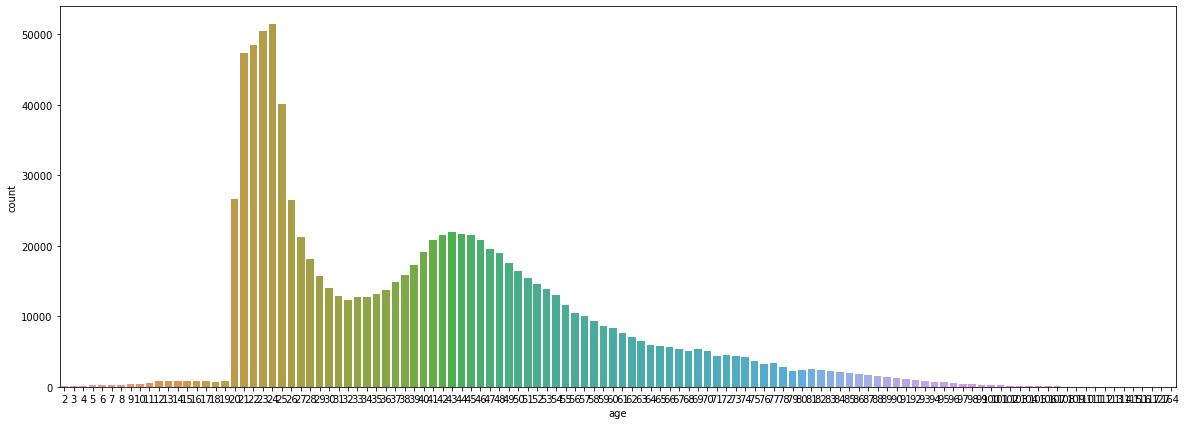

In [ ]:
fig = plt.figure(figsize =(20, 7))
sns.countplot(x="age",data=CustomerData)

In [ ]:
import matplotlib.pyplot as plt
import warnings

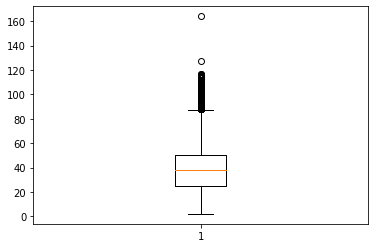

In [ ]:
plt.boxplot(CustomerData['age'])
warnings.filterwarnings("ignore")

In [ ]:
#Checking Percentiles
print(np.percentile(CustomerData['age'], 50))
print(np.percentile(CustomerData['age'], 90))
print(np.percentile(CustomerData['age'], 1))

38.0
64.0
20.0


**OBSERVATIONS:**
- Majority of the Users are between the the age of 18 and 26
- Distribution from 19 to 26 and from age 35 to 51 is Nicely distributed.
- The minimum age of the user is 2 and maximum age is 164.
- Maximum Number of Users are 51365 for age 24
- Minimum Number of Users is 1 for age 164,115,127
- 50% of Users have age less than 38
- 90% of Users have age less than 64
- Only 1% of Users have age less than 1

**Feature Engineering on AGE**
- Binning the age in 5 categries

In [ ]:
bins = [0,18,33,50,80,200]
label =['Children','Young','Middle','Old','Very_Old']
CustomerData['age'] = pd.cut(CustomerData['age'], bins,labels = label)

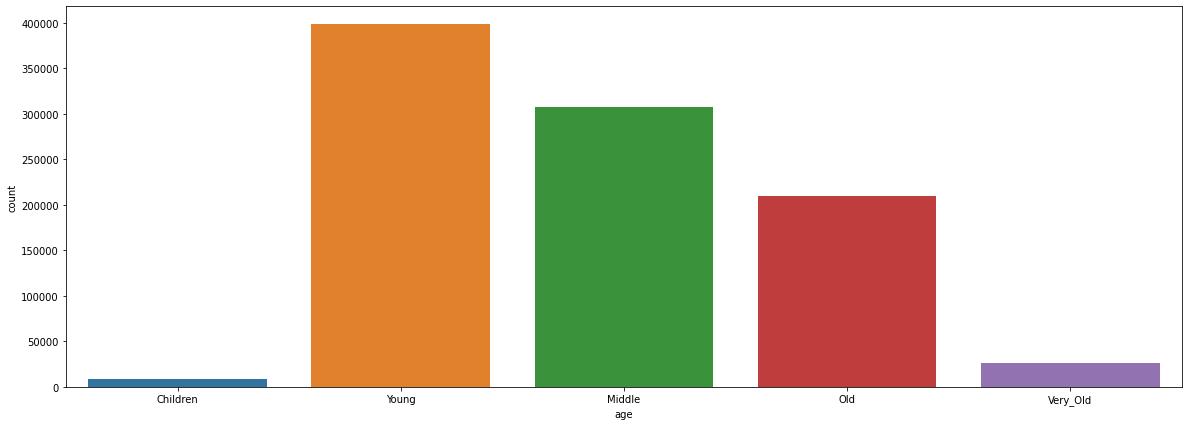

In [ ]:
#AFTER Binning
fig = plt.figure(figsize =(20,7))
sns.countplot(x="age",data=CustomerData)

**OBSERVATIONS:**
- Addition to above observations, Number of customers are decreasing After 'Young' Age

In [ ]:
vectorizer = CountVectorizer()
DATA_XTrain_age = vectorizer.fit_transform(CustomerData['age'].values)
DATA_XTrain_age_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_age.shape)

(949614, 5)


**6. sexo**
- Customers Gender

In [ ]:
print('Train')
print(CustomerData.sexo.value_counts())

Train
V    515577
H    434037
Name: sexo, dtype: Int64


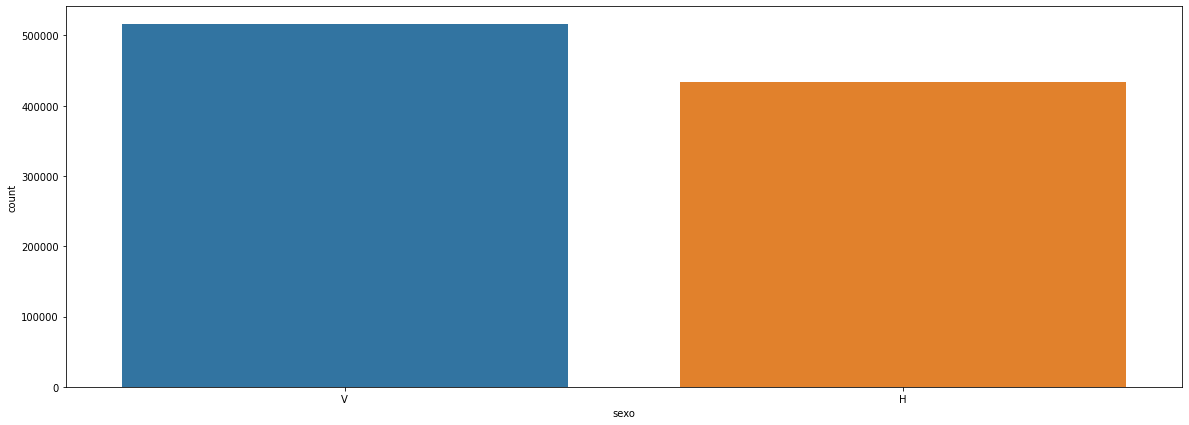

In [ ]:
fig = plt.figure(figsize =(20,7))
sns.countplot(x="sexo",data=CustomerData)

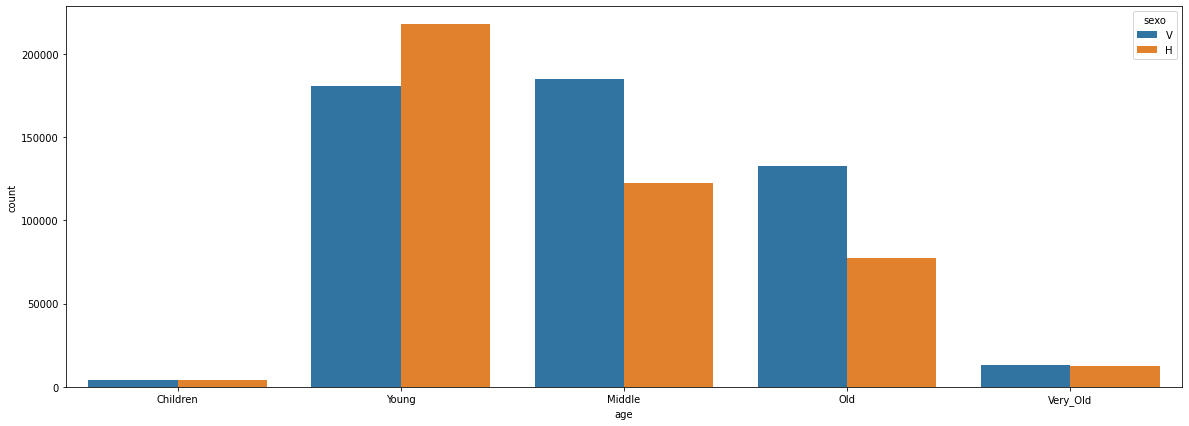

In [ ]:
#Countplot of age with gender
fig = plt.figure(figsize =(20,7))
sns.countplot(x="age",data=CustomerData,hue='sexo')

**OBSERVATION:**
- Interesting!!! There are more Female users than Male in the age group of 18 to 33
- Number of Male users is pretty high in all the other age groups

In [ ]:
vectorizer = CountVectorizer(token_pattern='\w')
DATA_XTrain_sexo = vectorizer.fit_transform(CustomerData['sexo'].values)
DATA_XTrain_sexo_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_sexo.shape)

(949614, 2)


**7. fecha_alta**
- The date in which the customer became as the first holder of a contract in the bank
- Year of join can be a good useful field here
- We can Consider Just the day of the month or week or Month for insightfull Analysis

In [ ]:
CustomerData['fecha_alta'].head()

0    1995-01-16
1    1995-01-16
2    2015-07-28
3    1995-01-16
4    1997-10-03
Name: fecha_alta, dtype: string

In [ ]:
CustomerData['fecha_alta'] = pd.to_datetime(CustomerData['fecha_alta'])

In [ ]:
#strftime("%B") -> To get month, strftime("%A")-> To get week Days
CustomerData['fecha_alta_month'] = CustomerData['fecha_alta'].dt.strftime("%B")
CustomerData['fecha_alta_day'] = CustomerData['fecha_alta'].dt.strftime("%A")

In [ ]:
#Creating Dataframe of value counts
fecha_alta_month_count = pd.DataFrame(CustomerData['fecha_alta_month'].value_counts())
fecha_alta_day_count = pd.DataFrame(CustomerData['fecha_alta_day'].value_counts())

**i) fecha_alta_month_count**

In [ ]:
fecha_alta_month_count.head(2)

,fecha_alta_month
October,156187
September,111533


In [ ]:
fecha_alta_month_count.tail(2)

,fecha_alta_month
May,48497
June,43855


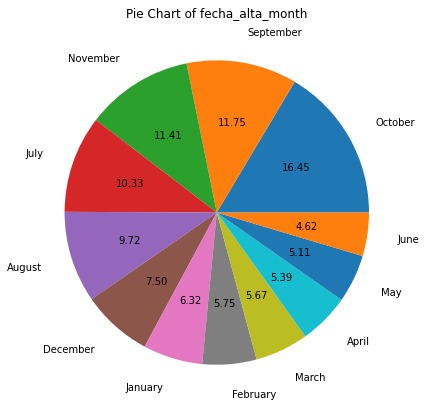

In [ ]:
f_da = CustomerData['fecha_alta_month'].value_counts().reset_index()

#Replacing other labels with blank space
#n - number of categories you want to show
n = 12
lenDl = len(fecha_alta_month_count) - 12
lenD = ['' for i in range(lenDl)]

mylabels = list(fecha_alta_month_count.index[:12])
mylabels = mylabels+lenD
mylabels = list(fecha_alta_month_count.index)

def autopct(pct):
  if pct > 1:
    return ('%.2f' % pct) 
  else:
    return ''

fig = plt.figure(figsize =(20,7))
CustomerData["fecha_alta_month"].value_counts().plot(x=None, y=None,title='Pie Chart of fecha_alta_month', kind='pie',pctdistance=0.6,autopct=autopct,labels=mylabels,labeldistance=1.2,ylabel='') 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

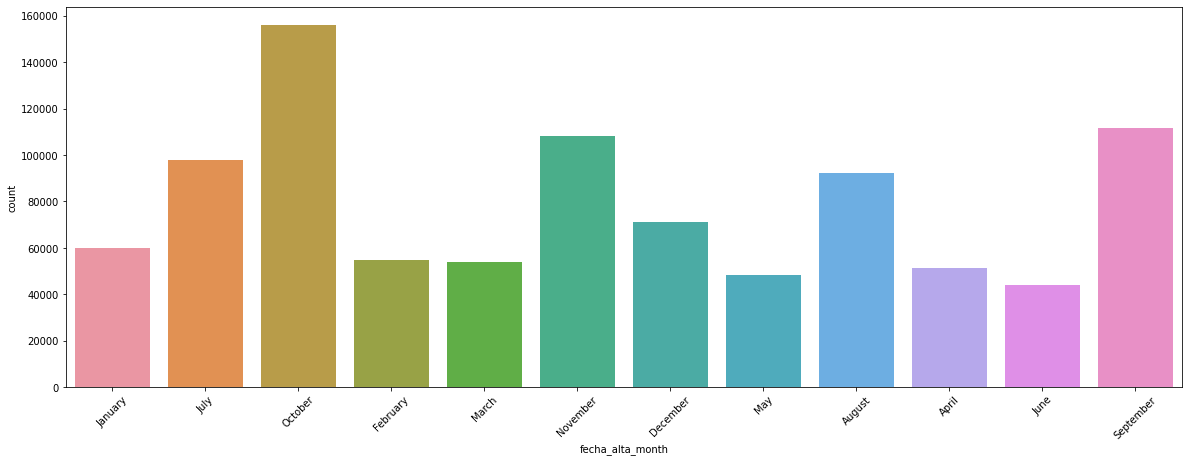

In [ ]:
fig = plt.figure(figsize =(20,7))
sns.countplot(x="fecha_alta_month",data=CustomerData)
plt.xticks(rotation=45)

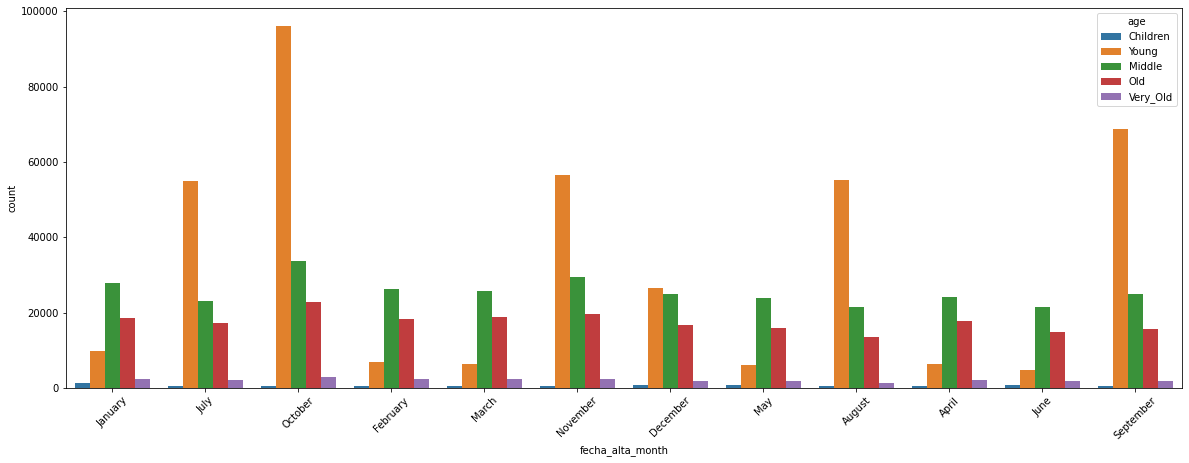

In [ ]:
fig = plt.figure(figsize =(20,7))
sns.countplot(x="fecha_alta_month",data=CustomerData,hue='age')
plt.xticks(rotation=45)
plt.title = 'Age and Months'

**OBSERVATION:**
- 50% of the Users became the first holder of a contract in 4 Months July,September,October,November
- Highest number of Users became the first holder of a contract in the month of October
- And least in June
- Young age Users tend to became the first holder of a contract from July to November
- Middle Age Users tend to became the first holder of a contract from January to June


In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(CustomerData['fecha_alta_month'].values)
DATA_XTrain_fecha_alta_month = vectorizer.transform(CustomerData['fecha_alta_month'].values)
DATA_XTest_fecha_alta_month = vectorizer.transform(CustomerData['fecha_alta_month'].values)
DATA_XTrain_fecha_alta_month_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_fecha_alta_month.shape)
print(DATA_XTest_fecha_alta_month.shape)

(949614, 12)
(949614, 12)


**ii) fecha_alta_day_count**

In [ ]:
fecha_alta_day_count.head(2)

,fecha_alta_day
Monday,226369
Wednesday,177890


In [ ]:
fecha_alta_day_count.tail(2)

,fecha_alta_day
Saturday,36941
Sunday,12391


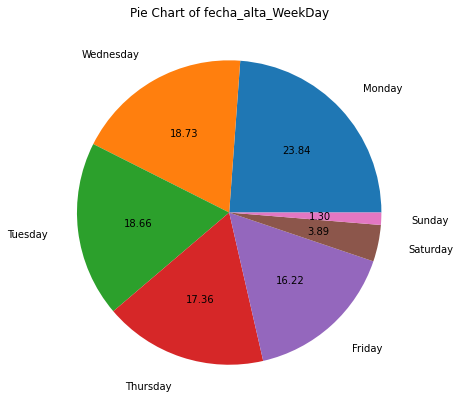

In [ ]:
f_da = CustomerData['fecha_alta_day'].value_counts().reset_index()

#Replacing other labels with blank space
#n - number of categories you want to show

mylabels = list(fecha_alta_day_count.index)

def autopct(pct):
  if pct > 1:
    return ('%.2f' % pct) 
  else:
    return ''
fig = plt.figure(figsize =(20,7))
CustomerData["fecha_alta_day"].value_counts().plot(x=None, y=None,title='Pie Chart of fecha_alta_WeekDay', kind='pie',pctdistance=0.6,autopct=autopct,labels=mylabels,labeldistance=1.2,ylabel='') 

Text(0.5, 0, 'WeekDay')

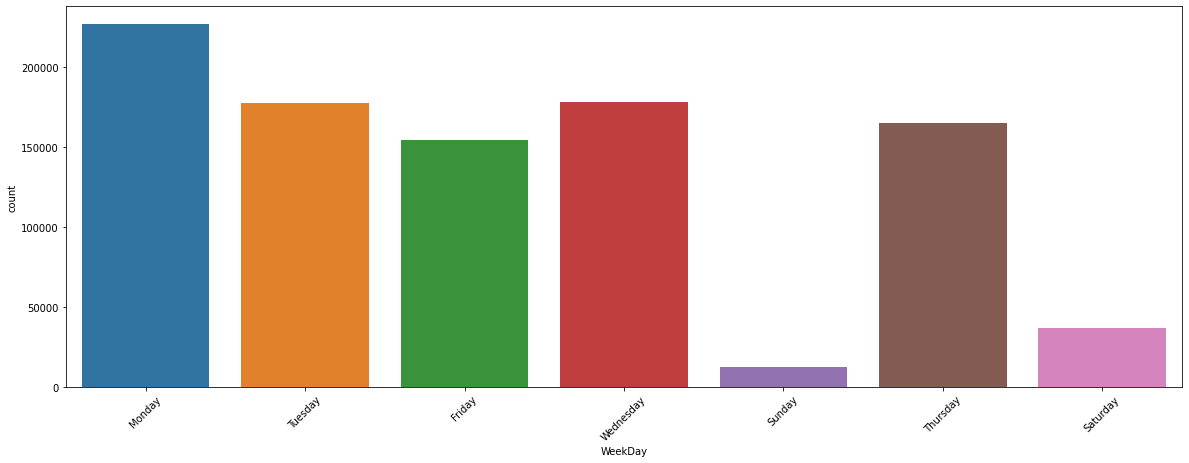

In [ ]:
fig = plt.figure(figsize =(20,7))
sns.countplot(x="fecha_alta_day",data=CustomerData)
plt.xticks(rotation=45)
plt.xlabel('WeekDay')

**Observations:**

- less than 5% of the Users became the first holder of a contract On Saturdays and Sundays
- Highest number of Users Choose Mondays to buy product
- And least number of Users Choose Sunday
- Young age Users tend to became the first holder of a contract from July to November
- Middle Age Users tend to became the first holder of a contract from January to June

In [ ]:
vectorizer = CountVectorizer()
DATA_XTrain_fecha_alta_day = vectorizer.fit_transform(CustomerData['fecha_alta_day'].values)
DATA_XTrain_fecha_alta_day_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_fecha_alta_day.shape)

(949614, 7)


**8. ind_nuevo**
- New customer Index. 1 if the customer registered in the last 6 months.

In [ ]:
CustomerData['ind_nuevo'] = CustomerData['ind_nuevo'].astype(np.int8)
print('Train')
print(CustomerData.ind_nuevo.value_counts())
print('-'*20)

Train
0    906393
1     43221
Name: ind_nuevo, dtype: int64
--------------------


In [ ]:
from scipy.sparse import hstack,csr_matrix

In [ ]:
DATA_XTrain_ind_nuevo = csr_matrix(CustomerData['ind_nuevo'].values.reshape(-1,1))
DATA_XTrain_ind_nuevo_colns = np.array(['ind_nuevo'])

In [ ]:
DATA_XTrain_ind_nuevo.shape

(949614, 1)

**9. Antiguedad**
- Customer seniority (in months)

In [ ]:
CustomerData['antiguedad'] = CustomerData['antiguedad'].astype(np.int64)

In [ ]:
#Lets bin Seniority of Months
bin = [-1000000,24,60,120,180,30000]
label = ['Low','Mid','High','Very_High','Highly_Exp']
CustomerData['antiguedad'] = pd.cut(CustomerData['antiguedad'],bin,labels=label)

print('Train')
print(CustomerData.antiguedad.value_counts())

Train
Mid           279403
Low           258599
Very_High     172342
High          140242
Highly_Exp     99028
Name: antiguedad, dtype: int64


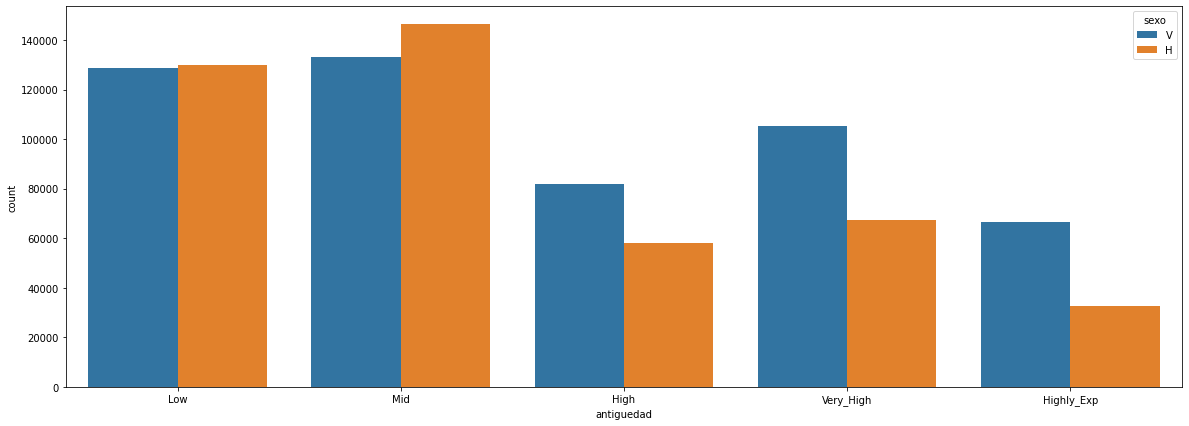

In [ ]:
fig = plt.figure(figsize =(20,7))
sns.countplot(x="antiguedad",data=CustomerData,hue='sexo')

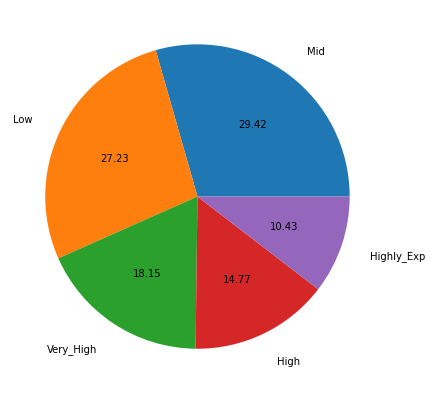

In [ ]:
def autopct(pct):
  return ('%.2f' % pct)
fig = plt.figure(figsize =(20,7))
CustomerData["antiguedad"].value_counts().plot(x=None, y=None, kind='pie',pctdistance=0.6,autopct=autopct,labeldistance=1.2,ylabel='') 

**Observations:**
- More than 56% of users have less than 60 months of Experience
- Number of users with 120 to 180 months of experiences are Lowest, and 24 to 60 months is highest
- Number of female users with experience 24 to 60 months are more than Male


In [ ]:
vectorizer = CountVectorizer()
DATA_XTrain_antiguedad = vectorizer.fit_transform(CustomerData['antiguedad'].values)
DATA_XTrain_antiguedad_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_antiguedad.shape)

(949614, 5)


**10. indrel**
- 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [ ]:
CustomerData['indrel'] = CustomerData['indrel'].astype(np.int8)
CustomerData['indrel'][CustomerData['indrel']==99] =0

print('Train')
print(CustomerData.indrel.value_counts())

Train
1    930285
0     19329
Name: indrel, dtype: int64


In [ ]:
DATA_XTrain_indrel = csr_matrix(CustomerData['indrel'].values.reshape(-1,1))
DATA_XTrain_indrel_colns = np.array(['indrel'])

In [ ]:
#indrel_1mes
CustomerData.loc[CustomerData['indrel_1mes']=='1.0','indrel_1mes'] = '1'
CustomerData.loc[CustomerData['indrel_1mes']=='2.0','indrel_1mes'] = '2'
CustomerData.loc[CustomerData['indrel_1mes']=='3.0','indrel_1mes'] = '3'
CustomerData.loc[CustomerData['indrel_1mes']=='4.0','indrel_1mes'] = '4'

print('Train')
print(CustomerData.indrel_1mes.value_counts())

Train
1    948598
3       747
2       131
P       101
4        37
Name: indrel_1mes, dtype: Int64


In [ ]:
vectorizer = CountVectorizer(token_pattern='\w')
DATA_XTrain_indrel_1mes = vectorizer.fit_transform(CustomerData['indrel_1mes'].values)
DATA_XTrain_indrel_1mes_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_indrel_1mes.shape)

(949614, 5)


**11. tiprel_1mes**
- Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential)



In [ ]:
print('Train')
print(CustomerData.tiprel_1mes.value_counts())

Train
I    548623
A    400106
P       784
R       101
Name: tiprel_1mes, dtype: Int64


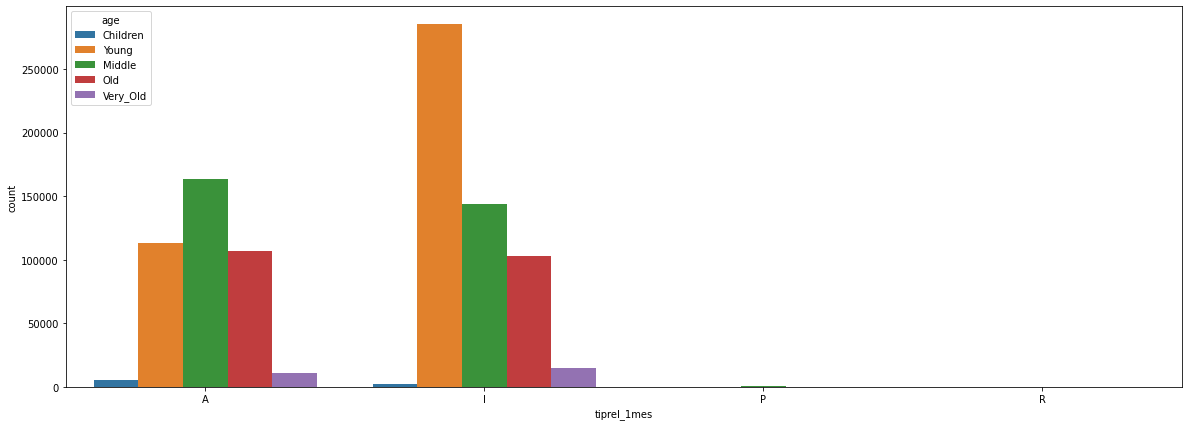

In [ ]:
fig = plt.figure(figsize =(20,7))
sns.countplot(x="tiprel_1mes",data=CustomerData,hue='age')

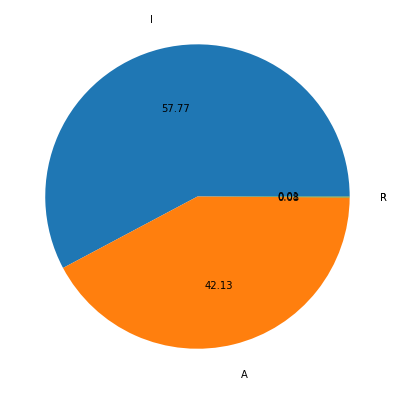

In [ ]:
def autopct(pct):
  return ('%.2f' % pct)
fig = plt.figure(figsize =(20,7))
CustomerData["tiprel_1mes"].value_counts().plot(x=None, y=None, kind='pie',pctdistance=0.6,autopct=autopct,labeldistance=1.2,ylabel='') 

**OBSERVATIONS:**
- More than 57% of the users are Inactive at the start of the Month
- More than 150000 people with age 33-50 are Active at the start of the Month
- More than 250000 people with age 18-33 are Inactive at the start of the Month

In [ ]:
vectorizer = CountVectorizer(token_pattern='\w')
DATA_XTrain_tiprel_1mes = vectorizer.fit_transform(CustomerData['tiprel_1mes'].values)
DATA_XTrain_tiprel_1mes_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_tiprel_1mes.shape)

(949614, 4)


**12. indresi**
- Residence index (S (Yes) or N (No) if the residence country is the same than the bank country)



In [ ]:
CustomerData.loc[CustomerData['indresi']=='S','indresi'] = '1'
CustomerData.loc[CustomerData['indresi']=='N','indresi'] = '0'
CustomerData['indresi'] = CustomerData['indresi'].astype(np.int8)


print('Train')
print(CustomerData.indresi.value_counts())

Train
1    945596
0      4018
Name: indresi, dtype: int64


In [ ]:
DATA_XTrain_indresi = csr_matrix(CustomerData['indresi'].values.reshape(-1,1))
DATA_XTrain_indresi_colns = np.array(['indresi'])

**indext**
- Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country)

In [ ]:
CustomerData.loc[CustomerData['indext']=='S','indext'] = '1'
CustomerData.loc[CustomerData['indext']=='N','indext'] = '0'
CustomerData['indext'] = CustomerData['indext'].astype(np.int8)


print('Train')
print(CustomerData.indext.value_counts())


Train
0    902024
1     47590
Name: indext, dtype: int64


In [ ]:
DATA_XTrain_indext = csr_matrix(CustomerData['indext'].values.reshape(-1,1))
DATA_XTrain_indext_colns = np.array(['indext'])

**13. canal_entrada**
- channel used by the customer to join

In [ ]:
print('Train')
print(CustomerData.canal_entrada.value_counts())

Train
KHE    254201
KAT    208365
KFC    203005
KHQ     76219
KHM     33215
        ...  
025         1
KDB         1
KDL         1
KDI         1
KGN         1
Name: canal_entrada, Length: 163, dtype: Int64


In [ ]:
f_da = CustomerData['canal_entrada'].value_counts().reset_index()
lenDl = len(f_da) - 4
lenD = ['' for i in range(lenDl)]
mylabels_ce = ['KHE','KAT','KFC','KHQ']
mylabels_ce = mylabels_ce+lenD

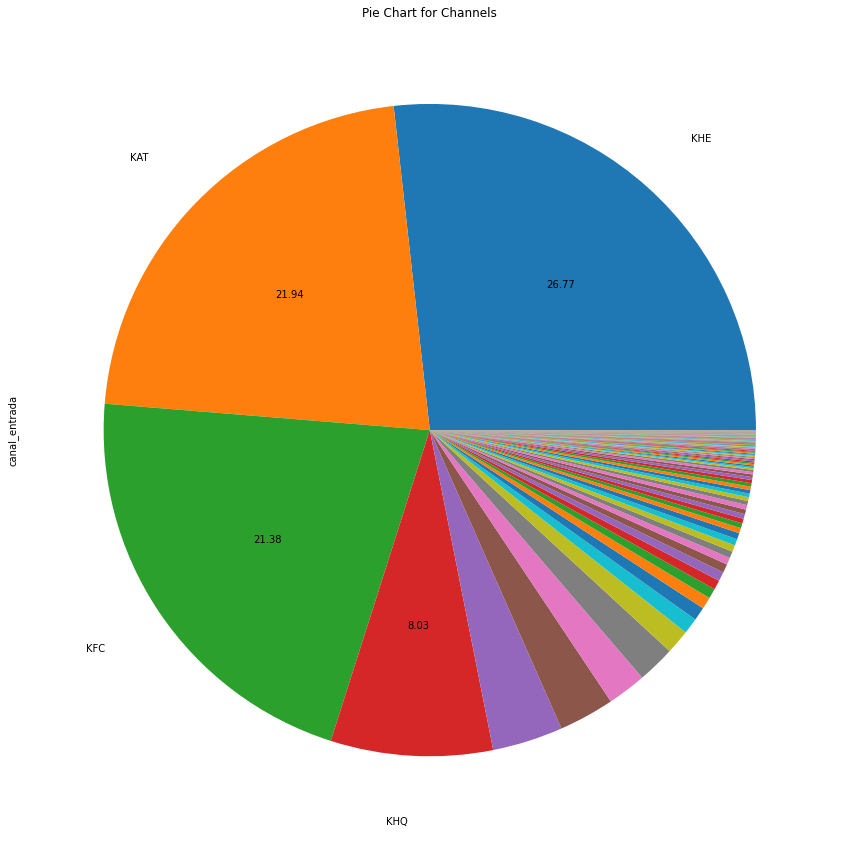

In [ ]:
def autopct(pct):
  if pct > 5:
    return ('%.2f' % pct) 
  else:
    return ''
fig = plt.figure(figsize =(20,15))
CustomerData["canal_entrada"].value_counts().plot(x=None, y=None, kind='pie',pctdistance=0.6,autopct=autopct,labels=mylabels_ce, labeldistance=1.2,title ='Pie Chart for Channels') 


<Figure size 2160x288 with 0 Axes>

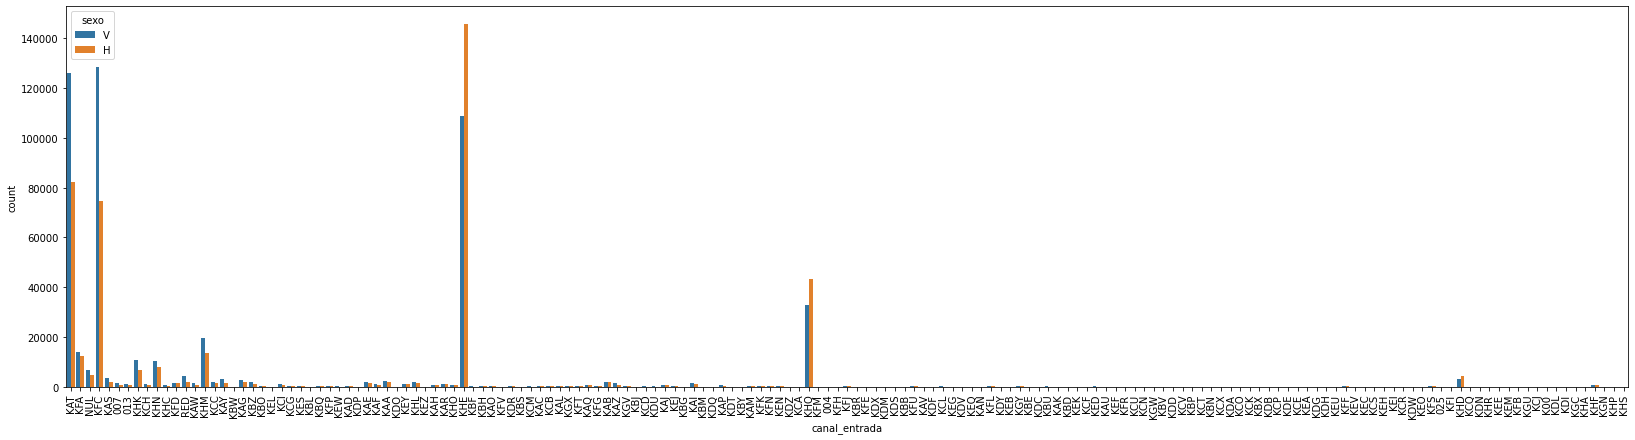

In [ ]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(4)
fig = plt.figure(figsize =(28,7))
sns.countplot(x="canal_entrada",data=CustomerData,hue='sexo')
plt.xticks(rotation=90)
plt.label='Channels Used by Customers'

plt.show()

<Figure size 2160x288 with 0 Axes>

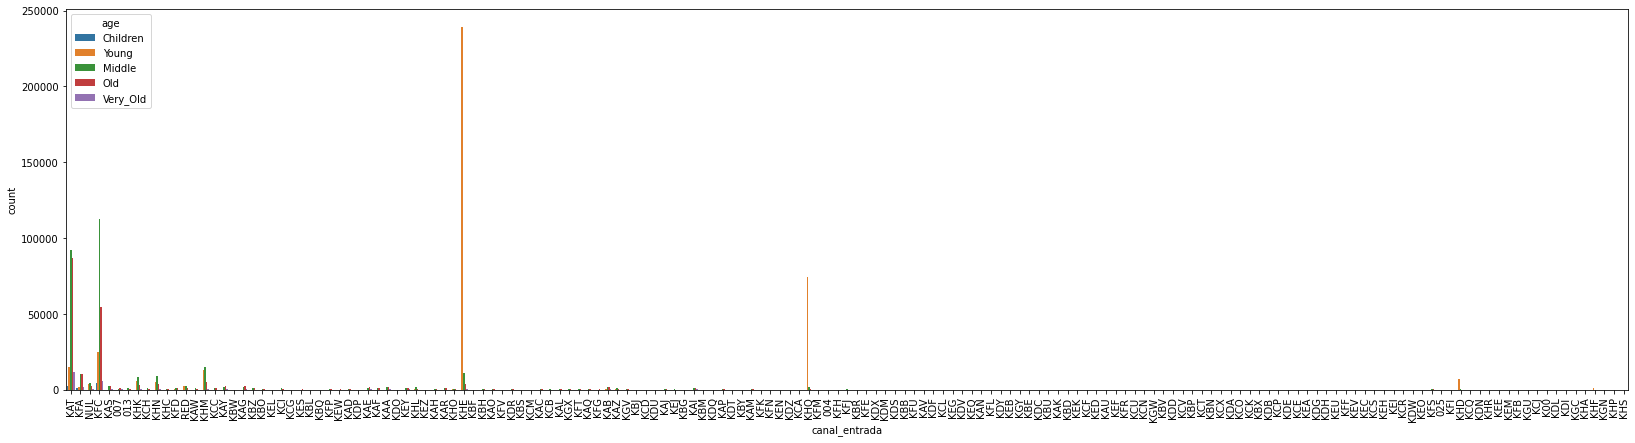

In [ ]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(4)
fig = plt.figure(figsize =(28,7))
sns.countplot(x="canal_entrada",data=CustomerData,hue='age')
plt.xticks(rotation=90)
plt.label='Channels Used by Customers'

plt.show()

**Observation:**
- 75% of the users use only 4 channels to join
- 'KHE' is the most used channel, followed by 'KAT' and 'KFC'
- KHE and KHQ channels has more Female users than male
- KHE and KHQ channels has more Young Userbase
- While, KFC and CAT has more Middle Aged userbase

In [ ]:
vectorizer = CountVectorizer()
DATA_XTrain_canal_entrada = vectorizer.fit_transform(CustomerData['canal_entrada'].values)
DATA_XTrain_canal_entrada_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_canal_entrada.shape)

(949614, 163)


**14. indfall**
- Deceased index. N/S

In [ ]:
CustomerData.loc[CustomerData['indfall']=='S','indfall'] = '1'
CustomerData.loc[CustomerData['indfall']=='N','indfall'] = '0'
CustomerData['indfall'] = CustomerData['indfall'].astype(np.int8)


print('Train')
print(CustomerData.indfall.value_counts())

Train
0    946884
1      2730
Name: indfall, dtype: int64


In [ ]:
DATA_XTrain_indfall = csr_matrix(CustomerData['indfall'].values.reshape(-1,1))
DATA_XTrain_indfall_colns = np.array(['indfall'])

**15. nomprov**
- Province name



In [ ]:
print(len(CustomerData['nomprov'].value_counts()))
CustomerData['nomprov'] = CustomerData['nomprov'].str.replace(', ','').str.replace(' ','')

53


In [ ]:
#Top 5 Provience
dfDummy =  pd.DataFrame(CustomerData['nomprov'].value_counts(),columns=['nomprov','Count'])
dfDummy = dfDummy.reset_index()
dfDummy.head(2)

,index,nomprov,Count
0,MADRID,304576,NaN
1,BARCELONA,90484,NaN


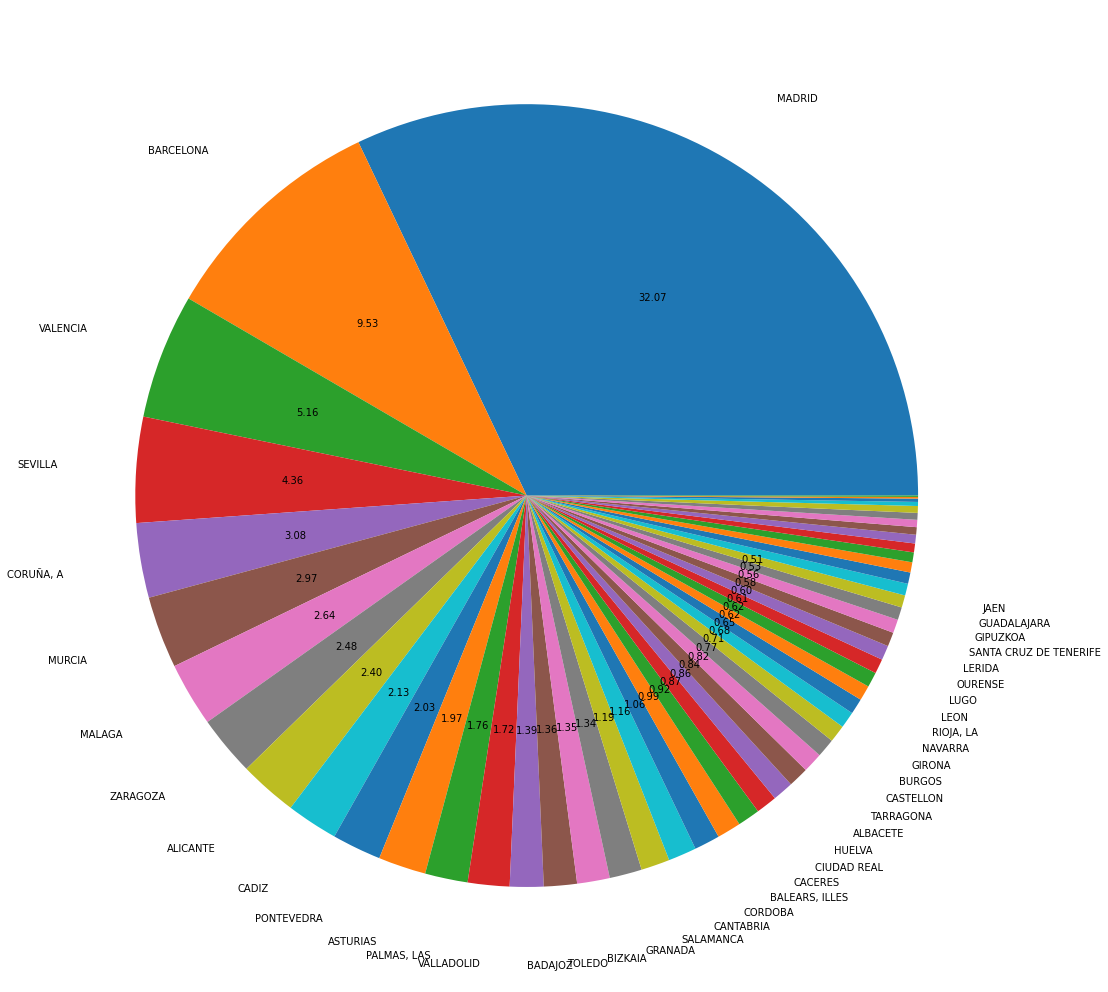

In [ ]:
mylabels = list(dfDummy['index'].iloc[:40])
lenDl = len(dfDummy) - len(mylabels)
lenD = ['' for i in range(lenDl)]

mylabels = mylabels+lenD

def autopct(pct):
  if pct > 0.5:
    return ('%.2f' % pct) 
  else:
    return ''

fig = plt.figure(figsize =(20,18))
CustomerData["nomprov"].value_counts().plot(x=None, y=None, kind='pie',pctdistance=0.6,autopct=autopct,labels=mylabels,labeldistance=1.2,ylabel='') 

<Figure size 1368x288 with 0 Axes>

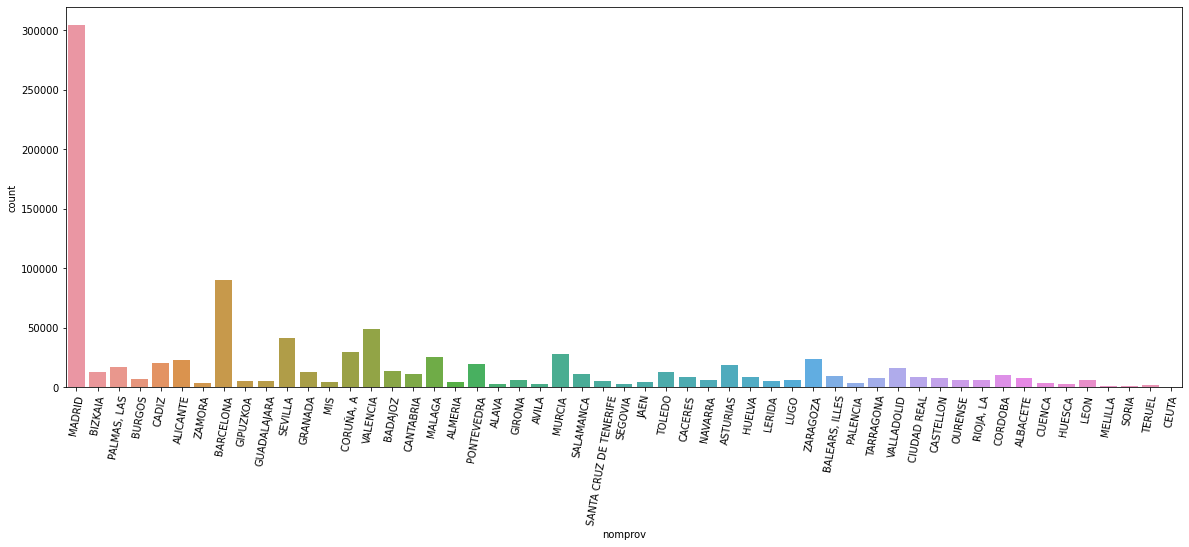

In [ ]:
f = plt.figure()
f.set_figwidth(19)
f.set_figheight(4)
fig = plt.figure(figsize =(20,7))
sns.countplot(x="nomprov",data=CustomerData)
plt.xticks(rotation=80)
plt.label='Countries'

plt.show()

<Figure size 1368x288 with 0 Axes>

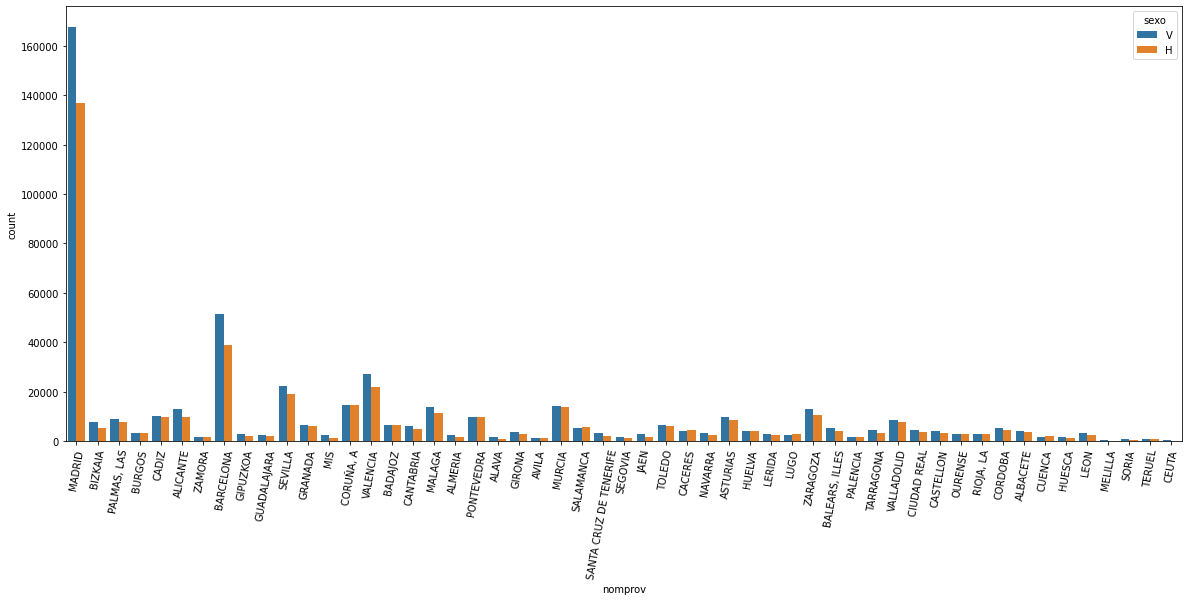

In [ ]:
f = plt.figure()
f.set_figwidth(19)
f.set_figheight(4)
fig = plt.figure(figsize =(20,8))
sns.countplot(x="nomprov",data=CustomerData,hue='sexo')
plt.xticks(rotation=80)
plt.label='Countries'

plt.show()

<Figure size 1368x288 with 0 Axes>

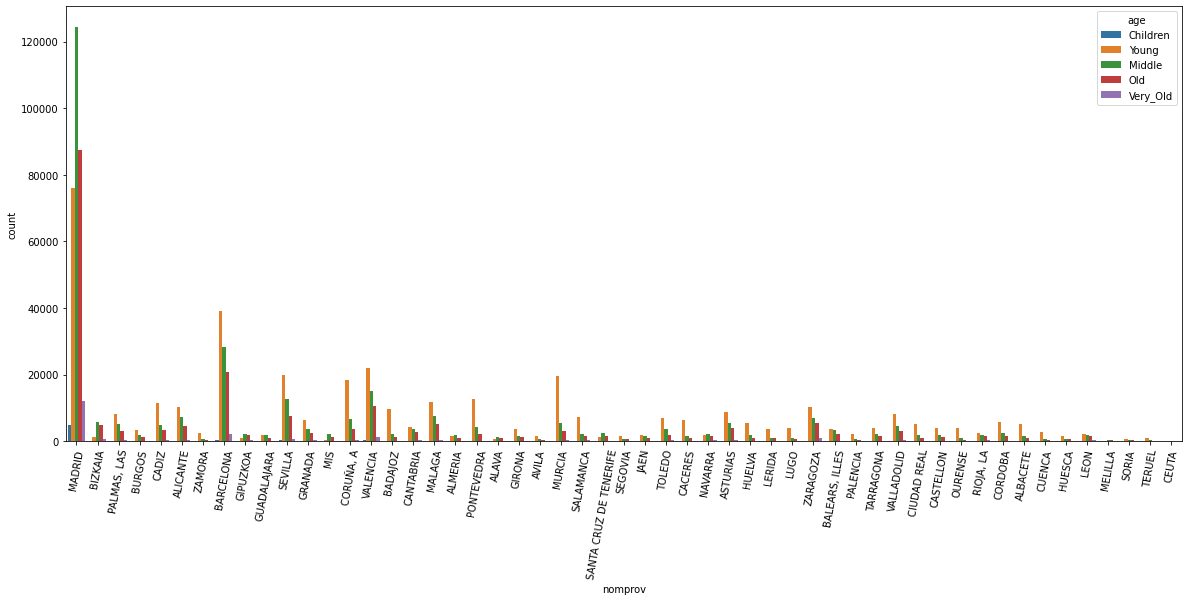

In [ ]:
f = plt.figure()
f.set_figwidth(19)
f.set_figheight(4)
fig = plt.figure(figsize =(20,8))
sns.countplot(x="nomprov",data=CustomerData,hue='age')
plt.xticks(rotation=80)
plt.title ='Countries with Age Distribution'

plt.show()

**Observations:**
- More than 50% of the users belongs to 5 Proviences
- Whopping 32.07% of the users belongs to MADRID Provience.
- Followed by BARCELONA(9.53%), VALENCIA(5.16%), SEVILLA(4.36%) and CORUNAA(3.08%)
- Countries like Barcelona, Valencia, Alicante, Malanga has more Femal Users than Male

In [ ]:
vectorizer = CountVectorizer()
DATA_XTrain_nomprov = vectorizer.fit_transform(CustomerData['nomprov'].values)
DATA_XTrain_nomprov_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_nomprov.shape)

(949614, 53)


**16. ind_actividad_cliente**
- Activity index (1, active customer; 0, inactive customer)


In [ ]:
CustomerData['ind_actividad_cliente'] = CustomerData['ind_actividad_cliente'].astype(np.int8)

print('Train')
print(CustomerData.ind_actividad_cliente.value_counts())

Train
0    552639
1    396975
Name: ind_actividad_cliente, dtype: int64


In [ ]:
DATA_XTrain_ind_actividad_cliente = csr_matrix(CustomerData['ind_actividad_cliente'].values.reshape(-1,1))
DATA_XTrain_ind_actividad_cliente_colns = np.array(['ind_actividad_cliente'])

**17. renta**
- Gross income of the household


In [ ]:
CustomerData['renta'] = CustomerData['renta'].astype(np.float64)

In [ ]:
print('50th Percentile ',np.percentile(CustomerData['renta'], 50))
print('90th Percentile ',np.percentile(CustomerData['renta'], 90))
print('99th Percentile ',np.percentile(CustomerData['renta'], 99))
print('25th Percentile ',np.percentile(CustomerData['renta'], 25))
print('75th Percentile ',np.percentile(CustomerData['renta'], 75))

50th Percentile  133060.35
90th Percentile  208258.9170000004
99th Percentile  495033.35459999996
25th Percentile  78742.7625
75th Percentile  134096.41893150797


In [ ]:
'''CustomerData['renta'] = CustomerData['renta'].groupby(CustomerData['nomprov']).transform(lambda x: x.fillna(x.mean()))'''

In [ ]:
#from the kaggle solution: It is proven that Converting rent to log(rent) improves model performance
CustomerData['renta'] = np.log(CustomerData['renta'])

In [ ]:
CustomerData['renta'].describe()

count    949614.000000
mean         11.624267
std           0.560916
min           7.092349
25%          11.273942
50%          11.798558
75%          11.806314
max          17.179158
Name: renta, dtype: float64

In [ ]:
from sklearn.preprocessing import MinMaxScaler
normalizerr = MinMaxScaler()

CustomerData['renta'] = normalizerr.fit_transform(CustomerData['renta'].values.reshape(-1,1))

**18. segmento**
- segmentation: 01 - VIP, 02 - Individuals 03 - college graduated


In [ ]:
print('Train')
print(CustomerData.segmento.value_counts())

Train
02 - PARTICULARES     563125
03 - UNIVERSITARIO    350480
01 - TOP               36009
Name: segmento, dtype: Int64


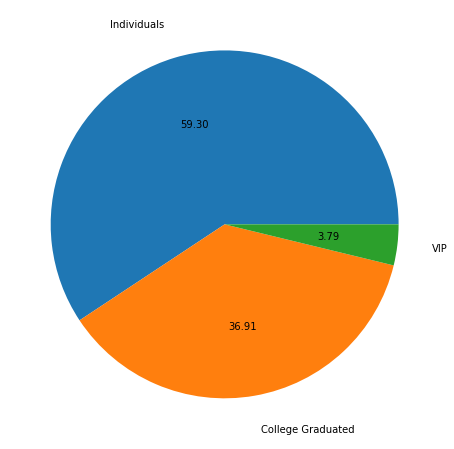

In [ ]:
#English Translation of labels
mylabels = ['Individuals','College Graduated','VIP']

def autopct(pct):
  return ('%.2f' % pct) 
fig = plt.figure(figsize =(20,8))
CustomerData["segmento"].value_counts().plot(x=None, y=None, kind='pie',pctdistance=0.6,autopct=autopct,labels=mylabels,labeldistance=1.2,ylabel='') 

**OBSERVATIONS:**
- Less than 4% of the total Users are VIP
- Close to 60% of the Users are not Graduated 

In [ ]:
CustomerData['segmento'] = CustomerData['segmento'].str.split(' - ').str[1]

In [ ]:
vectorizer = CountVectorizer()
DATA_XTrain_segmento = vectorizer.fit_transform(CustomerData['segmento'].values)
DATA_XTrain_segmento_colns = vectorizer.get_feature_names_out()
print(DATA_XTrain_segmento.shape)

(949614, 3)


**EDA On Product DataSet**

**1. ind_ahor_fin_ult1(Saving Account)**


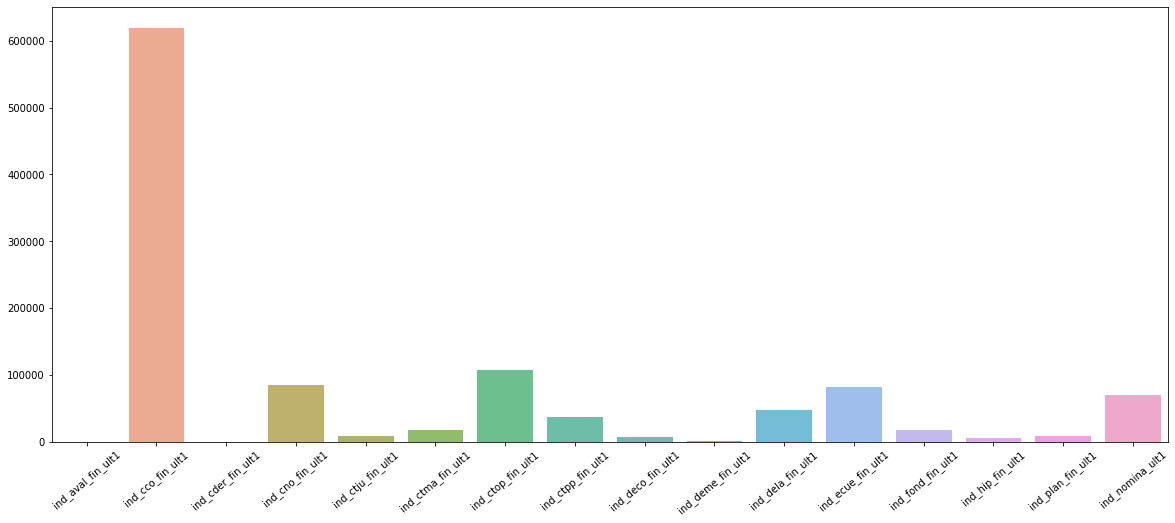

In [ ]:
#Taking Sum of Purchases of product
target_variables = list(ProductData.columns[1:])
target_counts = ProductData[target_variables].sum(axis=0)
plt.figure(figsize =(20,8))
sns.barplot(target_counts.index, target_counts.values, alpha=0.8)
plt.ticklabel_format(style = 'plain', axis='y')
plt.xticks(rotation=40)
plt.show()


**Obsevations:**
- ind_aval_fin_ult1 is the most bought product
- ind_ahor_fin_ult1,ind_cder_fin_ult1 and ind_deme_fin_ult1 are the least bought products

**Creating a Pickle File to save Modified Data**

In [ ]:
#Changing column names for All Categorical Features
#fecha_dato,ncodpers from df
ind_empleado_colns = [i+'_ind_empleado' for i in DATA_XTrain_ind_empleado_colns]
pais_residencia_colns = [i+'_pais_residencia' for i in DATA_XTrain_pais_residencia_colns]
sexo_colns = [i+'_sexo' for i in DATA_XTrain_sexo_colns]
age_colns = [i+'_age' for i in DATA_XTrain_age_colns]
fecha_alta_colns = [i+'_fecha_alta' for i in DATA_XTrain_fecha_alta_month_colns]+[i+'_fecha_alta' for i in DATA_XTrain_fecha_alta_day_colns]

ind_nuevo_colns = [i+'_ind_nuevo' for i in DATA_XTrain_ind_nuevo_colns]
antiguedad_colns = [i+'_antiguedad' for i in DATA_XTrain_antiguedad_colns]
indrel_colns = [i+'_indrel' for i in DATA_XTrain_indrel_colns]
indrel_1mes_colns = [i+'_indrel_1mes' for i in DATA_XTrain_indrel_1mes_colns]
tiprel_1mes_colns = [i+'_tiprel_1mes' for i in DATA_XTrain_tiprel_1mes_colns]
indresi_colns  = [i+'_indresi' for i in DATA_XTrain_indresi_colns]
indext_colns = [i+'_indext' for i in DATA_XTrain_indext_colns]
canal_entrada_colns = [i+'_canal_entrada' for i in DATA_XTrain_canal_entrada_colns]
indfall_colns = [i+'_indfall' for i in DATA_XTrain_indfall_colns]
nomprov_colns = [i+'_nomprov' for i in DATA_XTrain_nomprov_colns]
ind_actividad_cliente_colns = [i+'_ind_actividad_cliente' for i in DATA_XTrain_ind_actividad_cliente_colns]
segmento_colns = [i+'_segmento' for i in DATA_XTrain_segmento_colns]

New_Cust_Cols1 = ind_empleado_colns+pais_residencia_colns+sexo_colns+age_colns+fecha_alta_colns+ind_nuevo_colns+antiguedad_colns+indrel_colns+indrel_1mes_colns
New_Cust_Cols2 = tiprel_1mes_colns+indresi_colns+indext_colns+canal_entrada_colns+indfall_colns+nomprov_colns+ind_actividad_cliente_colns+segmento_colns
New_Cust_Cols = New_Cust_Cols1+New_Cust_Cols2
New_Cust_Cols

['a_ind_empleado',
 'b_ind_empleado',
 'f_ind_empleado',
 'n_ind_empleado',
 's_ind_empleado',
 'ad_pais_residencia',
 'ae_pais_residencia',
 'al_pais_residencia',
 'ao_pais_residencia',
 'ar_pais_residencia',
 'at_pais_residencia',
 'au_pais_residencia',
 'ba_pais_residencia',
 'be_pais_residencia',
 'bg_pais_residencia',
 'bm_pais_residencia',
 'bo_pais_residencia',
 'br_pais_residencia',
 'by_pais_residencia',
 'bz_pais_residencia',
 'ca_pais_residencia',
 'cd_pais_residencia',
 'cf_pais_residencia',
 'cg_pais_residencia',
 'ch_pais_residencia',
 'ci_pais_residencia',
 'cl_pais_residencia',
 'cm_pais_residencia',
 'cn_pais_residencia',
 'co_pais_residencia',
 'cr_pais_residencia',
 'cu_pais_residencia',
 'cz_pais_residencia',
 'de_pais_residencia',
 'dj_pais_residencia',
 'dk_pais_residencia',
 'do_pais_residencia',
 'dz_pais_residencia',
 'ec_pais_residencia',
 'ee_pais_residencia',
 'eg_pais_residencia',
 'es_pais_residencia',
 'et_pais_residencia',
 'fi_pais_residencia',
 'fr_pai

In [ ]:
len(New_Cust_Cols)

388

In [ ]:
#Customer Data
Cust_DATA_XTrain = hstack((DATA_XTrain_ind_empleado,
DATA_XTrain_pais_residencia,
DATA_XTrain_sexo,
DATA_XTrain_age,
DATA_XTrain_fecha_alta_month,
DATA_XTrain_fecha_alta_day,
DATA_XTrain_ind_nuevo,
DATA_XTrain_antiguedad,
DATA_XTrain_indrel,
DATA_XTrain_indrel_1mes,
DATA_XTrain_tiprel_1mes,
DATA_XTrain_indresi,
DATA_XTrain_indext,
DATA_XTrain_canal_entrada,
DATA_XTrain_indfall,
DATA_XTrain_nomprov,
DATA_XTrain_ind_actividad_cliente,
DATA_XTrain_segmento)).tocsr()

In [ ]:
Cust_DATA_XTrain = Cust_DATA_XTrain.astype(np.int8)
Cust_DATA_XTrain.shape

(949614, 388)

In [ ]:
Cust_DATA_XTrainDF = pd.DataFrame.sparse.from_spmatrix(Cust_DATA_XTrain, columns=New_Cust_Cols)
Cust_DATA_XTrainDF.head()

,a_ind_empleado,b_ind_empleado,f_ind_empleado,n_ind_empleado,s_ind_empleado,ad_pais_residencia,ae_pais_residencia,al_pais_residencia,ao_pais_residencia,ar_pais_residencia,...,teruel_nomprov,toledo_nomprov,valencia_nomprov,valladolid_nomprov,zamora_nomprov,zaragoza_nomprov,ind_actividad_cliente_ind_actividad_cliente,particulares_segmento,top_segmento,universitario_segmento
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [ ]:
#Null Check
[print(i,j) for i,j in dict(Cust_DATA_XTrainDF.isna().sum()).items() if j!=0]

[]

In [ ]:
renta = CustomerData.loc[:,'renta'].values.reshape(-1,1)
rentaDF = pd.DataFrame(renta,columns=['renta'])

print(rentaDF.shape)


(949614, 1)


In [ ]:
CustomerData.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,indresi,indext,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento,fecha_alta_month,fecha_alta_day
0,2016-05-28,15889,F,ES,V,Old,1995-01-16,0,Highly_Exp,1,...,1,0,KAT,0,MADRID,1,0.555447,TOP,January,Monday
1,2016-05-28,15890,A,ES,V,Old,1995-01-16,0,Highly_Exp,1,...,1,0,KAT,0,MADRID,1,0.404941,TOP,January,Monday
2,2015-08-28,15891,N,ES,H,Old,2015-07-28,0,Highly_Exp,0,...,1,0,KAT,0,MADRID,0,0.467340,PARTICULARES,July,Tuesday
3,2016-05-28,15892,F,ES,H,Old,1995-01-16,0,Highly_Exp,1,...,1,0,KAT,0,MADRID,1,0.582969,TOP,January,Monday
4,2016-05-28,15893,N,ES,V,Old,1997-10-03,0,Highly_Exp,1,...,1,0,KAT,0,MADRID,1,0.582969,PARTICULARES,October,Friday


In [ ]:
print(Cust_DATA_XTrainDF.shape)
print(CustomerData.loc[:,'ncodpers'].shape)
print(rentaDF.shape)
print(Prod_Data_YTrain.shape)

(949614, 388)
(949614,)
(949614, 1)
(949614, 24)


In [ ]:
#Storing All Labels into list
Prod_Cols = list(Prod_Data_YTrain.columns)
print(Prod_Cols)
print(len(Prod_Cols))

['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1', 'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1', 'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1', 'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1', 'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1', 'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1', 'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']
24


In [ ]:
AllCols = ['ncodpers','renta']+New_Cust_Cols+Prod_Cols
print(len(AllCols))
#Creating Dictionary
AllColsDict = dict()
for i,val in enumerate(AllCols):
  AllColsDict[i]=val

414


In [ ]:
#Creating New DataFrame
NewTrainData = pd.concat([CustomerData.iloc[:,1],rentaDF,Cust_DATA_XTrainDF,Prod_Data_YTrain],axis=1)
NewTrainData.rename(columns=AllColsDict,inplace=True)

In [ ]:
NewTrainData.head()

,ncodpers,renta,a_ind_empleado,b_ind_empleado,f_ind_empleado,n_ind_empleado,s_ind_empleado,ad_pais_residencia,ae_pais_residencia,al_pais_residencia,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,15889,0.555447,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,15890,0.404941,1,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,1,1
2,15891,0.467340,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15892,0.582969,0,0,1,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,1
4,15893,0.582969,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
print(NewTrainData.shape)
#All the values after column 2 are binary, So we can convert their datatype to int8
NewTrainData = NewTrainData.copy()
NewTrainData.iloc[:,2:] = NewTrainData.iloc[:,2:].astype(np.int8)

In [ ]:
'''NewTrainData.to_pickle('Final_Data.pkl')'''

In [ ]:
'''from google.colab import files
files.download("Final_Data.pkl")'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>